# Overview

1. Project Instructions & Prerequisites
2. Learning Objectives
3. Data Preparation
4. Create Categorical Features with TF Feature Columns
5. Create Continuous/Numerical Features with TF Feature Columns
6. Build Deep Learning Regression Model with Sequential API and TF Probability Layers
7. Evaluating Potential Model Biases with Aequitas Toolkit


#  1. Project Instructions & Prerequisites

EHR data is becoming a key source of real-world evidence (RWE) for the pharmaceutical industry and regulators to [make decisions on clinical trials](https://www.fda.gov/news-events/speeches-fda-officials/breaking-down-barriers-between-clinical-trials-and-clinical-care-incorporating-real-world-evidence). Drugs that are ready for Phase III clinical trial testing undergo administering and screening. For example, a very unique and sensitive diabetes drug requires administering and screening the drug over at least 5-7 days of time in the hospital with frequent monitoring/testing and patient medication adherence training with a mobile application. A predictive model was built that can identify which type of patients the drug should be tested on. Target patients were people that were likely to be in the hospital for this duration of time and would not incur significant additional costs for administering this drug to the patient and monitoring.  

In order to achieve this goal a regression model was built that could predict the estimated hospitalization time for a patient and use this to select/filter patients for the study.


**Expected Hospitalization Time Regression Model:** Utilizing a synthetic dataset(denormalized at the line level augmentation) built off of the UCI Diabetes readmission dataset, a regression model was built that predicts the expected days of hospitalization time and then convert this to a binary prediction of whether to include or exclude that patient from the clinical trial.

This project demonstrated the importance of building the right data representation at the encounter level, with appropriate filtering and preprocessing/feature engineering of key medical code sets. This model was also analyzed and interpreted for biases across key demographic groups. 

### Dataset

Due to healthcare PHI regulations (HIPAA, HITECH), there are limited number of publicly available datasets and some datasets require training and approval. Therefore, dataset is limited in its representation of some key features such as diagnosis codes which are usually an unordered list in 835s/837s (the HL7 standard interchange formats used for claims and remits).

# 2.  Learning Objectives

This project results in:
   - Use the Tensorflow Dataset API to scalably extract, transform, and load datasets and build datasets aggregated at the line, encounter, and patient data levels(longitudinal)
   - Analyze EHR datasets to check for common issues (data leakage, statistical properties, missing values, high cardinality) by performing exploratory data analysis.
   - Create categorical features from Key Industry Code Sets (ICD, CPT, NDC) and reduce dimensionality for high cardinality features by using embeddings 
   - Create derived features(bucketing, cross-features, embeddings) utilizing Tensorflow feature columns on both continuous and categorical input features
   - SWBAT use the Tensorflow Probability library to train a model that provides uncertainty range predictions that allow for risk adjustment/prioritization and triaging of predictions
   - Analyze and determine biases for a model for key demographic groups by evaluating performance metrics across groups by using the Aequitas framework 


# 3. Data Preparation

In [1]:
# from __future__ import absolute_import, division, print_function, unicode_literals
import os
import numpy as np
#os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp
#import tensorflow_data_validation as tfdv
import matplotlib.pyplot as plt
import pandas as pd
import aequitas as ae
import math
# Put all of the helper functions in utils
from utils import build_vocab_files, show_group_stats_viz, aggregate_dataset, preprocess_df, df_to_dataset, posterior_mean_field, prior_trainable
pd.set_option('display.max_columns', 500)
# this allows changes to be made in project_utils.py and the file is reloaded every time you run a code block
%load_ext autoreload
%autoreload 2

## Dataset Loading and Schema Review

Load the dataset and view a sample of the dataset along with reviewing the schema reference files to gain a deeper understanding of the dataset. The dataset is located at the following path https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/starter_code/data/final_project_dataset.csv. Also, review the information found in the data schema https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/

In [2]:
dataset_path = "./data/final_project_dataset.csv"
df = pd.read_csv(dataset_path)
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,250.83,?|?,0,0,0,41,1,1,0,NaN,None,None,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Ch,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,648,250|V27,2,1,0,11,6,13,5,0378-1110,None,None,No,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,8,250.43|403,0,0,0,44,7,16,1,68071-1701,None,None,Ch,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO


## Determine Level of Dataset (Line or Encounter)

Based off of analysis of the data, what level is this dataset? Is it at the line or encounter level? Are there any key fields besides the encounter_id and patient_nbr fields that we should use to aggregate on? Knowing this information will help inform us what level of aggregation is necessary for future steps and is a step that is often overlooked. 

In [3]:
# Determine level of data
if len(df) > df.encounter_id.nunique():
    print("Line Level")
elif len(df) == df.encounter_id.nunique():
    print("Encounter Level")

Line Level


Since the number of records is greater than the number of encounters, this dataset is at the line level.

## Analyze Dataset

Utilizing Padnas and Seaborn/matplotlib, perform exploratory data analysis on the dataset. We will address the following questions:  
    - a. Field(s) with high amount of missing/zero values
    - b. Which numerical field(s) has/have a Gaussian(normal) distribution shape?
    - c. Which field(s) have high cardinality and why (ndc_code is one feature)
    - d. Describe the demographic distributions in the dataset for the age and gender fields.
    


Use the Tensorflow Data Validation and Analysis library to complete. 
- The Tensorflow Data Validation and Analysis library(https://www.tensorflow.org/tfx/data_validation/get_started) is a useful tool for analyzing and summarizing dataset statistics. It is especially useful because it can scale to large datasets that do not fit into memory. 

In [18]:
# ######NOTE: The visualization will only display in Chrome browser. ########
full_data_stats = tfdv.generate_statistics_from_csv(data_location='./data/final_project_dataset.csv') 
tfdv.visualize_statistics(full_data_stats)

## Reduce Dimensionality of the NDC Code Feature

NDC codes are a common format to represent the wide variety of drugs that are prescribed for patient care in the United States. The challenge is that there are many codes that map to the same or similar drug. We have the ndc drug lookup file https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/ndc_lookup_table.csv derived from the National Drug Codes List site(https://ndclist.com/). Using this file, we will reduce the dimensionality of this field and create a new field in the dataset called "generic_drug_name" in the output dataframe. 

In [4]:
#NDC code lookup file
ndc_code_path = "./medication_lookup_tables/final_ndc_lookup_table"
ndc_code_df = pd.read_csv(ndc_code_path)

In [5]:
from project_utils import reduce_dimension_ndc

In [6]:
reduce_dim_df = reduce_dimension_ndc(df, ndc_code_df)

In [7]:
# Number of unique values should be less for the new output field
assert df['ndc_code'].nunique() > reduce_dim_df['generic_drug_name'].nunique()

## Select First Encounter for each Patient 

In order to simplify the aggregation of data for the model, we will only select the first encounter for each patient in the dataset. This is to reduce the risk of data leakage of future patient encounters and to reduce complexity of the data transformation and modeling steps. We will assume that sorting in numerical order on the encounter_id provides the time horizon for determining which encounters come before and after another.

In [8]:
%%time
from project_utils import select_first_encounter
first_encounter_df = select_first_encounter(reduce_dim_df)

CPU times: user 17.9 s, sys: 167 ms, total: 18.1 s
Wall time: 18.1 s


In [9]:
# unique patients in transformed dataset
unique_patients = first_encounter_df['patient_nbr'].nunique()
print("Number of unique patients:{}".format(unique_patients))

# unique encounters in transformed dataset
unique_encounters = first_encounter_df['encounter_id'].nunique()
print("Number of unique encounters:{}".format(unique_encounters))

original_unique_patient_number = reduce_dim_df['patient_nbr'].nunique()
# number of unique patients should be equal to the number of unique encounters and patients in the final dataset
assert original_unique_patient_number == unique_patients
assert original_unique_patient_number == unique_encounters
print("Tests passed!!")

Number of unique patients:71518
Number of unique encounters:71518
Tests passed!!


## One-hot Encode list of generic drugs

The list of drugs in columns "generic_drug_name" are one-hot encoded to be set as inputs for the model

In [10]:
exclusion_list = ['generic_drug_name']
grouping_field_list = [c for c in first_encounter_df.columns if c not in exclusion_list]
agg_drug_df, ndc_col_list = aggregate_dataset(first_encounter_df, grouping_field_list, 'generic_drug_name')

In [11]:
assert len(agg_drug_df) == agg_drug_df['patient_nbr'].nunique() == agg_drug_df['encounter_id'].nunique()

In [12]:
agg_drug_df.head()

,patient_nbr,encounter_id,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted,generic_drug_name,Acarbose,Glimepiride,Glipizide,Glipizide And Metformin Hcl,Glipizide And Metformin Hydrochloride,Glyburide,Glyburide And Metformin Hydrochloride,Glyburide-metformin Hydrochloride,Human Insulin,Insulin Human,Metformin Hcl,Metformin Hydrochloride,Miglitol,Nateglinide,Pioglitazole And Metformin Hydrochloride,Pioglitazone,Pioglitazone Hydrochloride And Glimepiride,Repaglinide,Rosiglitazone Maleate,Tolazamide,Tolbutamide,nan
0,135,24437208,Caucasian,Female,[50-60),?,2,1,1,8,?,Cardiology,401,997|560,0,0,0,77,8,33,6,"68071-1701,42291-559,0093-9364",None,None,Ch,<30,"Glyburide,Metformin Hydrochloride,Human Insulin",0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
1,378,29758806,Caucasian,Female,[50-60),?,3,1,1,2,?,Surgery-Neuro,722,305|250,0,0,0,49,3,11,1,nan,None,None,No,NO,nan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,729,189899286,Caucasian,Female,[80-90),?,1,3,7,4,MC,InternalMedicine,820,493|E880,0,0,0,68,9,23,2,0615-7982,None,>7,No,NO,Metformin Hydrochloride,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,774,64331490,Caucasian,Female,[80-90),?,1,1,7,3,?,InternalMedicine,274,427|416,0,0,0,46,9,20,0,"0378-7185,0115-1743",None,>8,Ch,NO,"Glyburide,Metformin Hydrochloride",0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,927,14824206,AfricanAmerican,Female,[30-40),?,1,1,7,5,?,InternalMedicine,590,220|250,0,0,0,49,3,5,0,42571-104,None,None,No,NO,Glimepiride,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
agg_drug_df.payer_code.unique()

array(['?', 'MC', 'BC', 'UN', 'MD', 'HM', 'CP', 'DM', 'PO', 'SP', 'CM',
       'OT', 'SI', 'WC', 'MP', 'CH', 'OG', 'FR'], dtype=object)

## Prepare Fields and Cast Dataset 

### Feature Selection

After aggregating the dataset to the right level, we can do feature selection (we will include the ndc_col_list, dummy column features too). In the block below, we select the categorical and numerical features that will be used for the model, so that we can create a dataset subset. 

In [14]:
categorical_col_list = ['race', 'weight', 'gender', 'age', 'medical_specialty', 'primary_diagnosis_code', 'max_glu_serum', 'A1Cresult', 'change', 'readmitted', 'admission_type_id',  'discharge_disposition_id', 'admission_source_id'] + ndc_col_list
numerical_col_list = ['number_outpatient',
                     'number_inpatient',
                     'number_emergency',
                     'num_lab_procedures',
                     'number_diagnoses',
                     'num_medications',
                     'num_procedures']
PREDICTOR_FIELD = 'time_in_hospital'

In [15]:
def select_model_features(df, categorical_col_list, numerical_col_list, PREDICTOR_FIELD, grouping_key='patient_nbr'):
    selected_col_list = [grouping_key] + [PREDICTOR_FIELD] + categorical_col_list + numerical_col_list   
    return agg_drug_df[selected_col_list]


In [16]:
selected_features_df = select_model_features(agg_drug_df, categorical_col_list, numerical_col_list,
                                            PREDICTOR_FIELD)

### Preprocess Dataset - Casting and Imputing  

We will cast and impute the dataset before splitting so that we do not have to repeat these steps across the splits in the next step. For imputing, there can be deeper analysis into which features to impute and how to impute but for the sake of time, we are taking a general strategy of imputing zero for only numerical features. 

In [70]:
processed_df = preprocess_df(selected_features_df, categorical_col_list, 
        numerical_col_list, PREDICTOR_FIELD, categorical_impute_value='nan', numerical_impute_value=0)

/Users/kush/Documents/Github Repos/Patient-Selection-for-Diabetes-Drug-Testing-using-EHR-Data/starter_code/utils.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,predictor] = df[predictor].astype(float)
/Users/kush/Documents/Github Repos/Patient-Selection-for-Diabetes-Drug-Testing-using-EHR-Data/starter_code/utils.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[c] = cast_df(df, c, d_type=str)
/Users/kush/Documents/Github Repos/Patient-Selection-for-Diabetes-Drug-Testing-using-EHR-Data/s

In [18]:
from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence
rs = RandomState(MT19937(SeedSequence(42)))
index = agg_drug_df.index.to_numpy().copy()
rs.shuffle(index)

## Split Dataset into Train, Validation, and Test Partitions

In order to prepare the data for being trained and evaluated by a deep learning model, we will split the dataset into three partitions, with the validation partition used for optimizing the model hyperparameters during training. One of the key parts is that we need to be sure that the data does not accidently leak across partitions.

The function 'patient_dataset_splitter' splits the input dataset into three partitions(train, validation, test) with approximately 60%/20%/20%  train/validation/test split

In [19]:
from project_utils import patient_dataset_splitter
d_train, d_val, d_test = patient_dataset_splitter(processed_df, 'patient_nbr')

In [20]:
assert len(d_train) + len(d_val) + len(d_test) == len(processed_df)
print("Test passed for number of total rows equal!")

Test passed for number of total rows equal!


In [21]:
assert (d_train['patient_nbr'].nunique() + d_val['patient_nbr'].nunique() + d_test['patient_nbr'].nunique()) == agg_drug_df['patient_nbr'].nunique()
print("Test passed for number of unique patients being equal!")

Test passed for number of unique patients being equal!


## Demographic Representation Analysis of Split

After the split, we should check to see the distribution of key features/groups and make sure that there is representative samples across the partitions. The show_group_stats_viz function in the utils.py file can be used to group and visualize different groups and dataframe partitions.

### Label Distribution Across Partitions

Below you can see the distributution of the label across your splits. Are the histogram distribution shapes similar across partitions?

time_in_hospital
1.0     10717
2.0     12397
3.0     12701
4.0      9567
5.0      6839
6.0      5171
7.0      3999
8.0      2919
9.0      1990
10.0     1558
11.0     1241
12.0      955
13.0      795
14.0      669
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


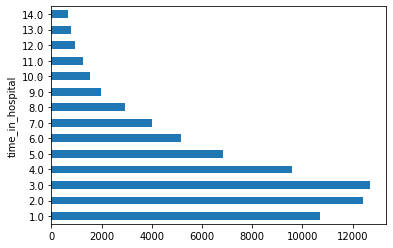

In [22]:
show_group_stats_viz(processed_df, PREDICTOR_FIELD)

time_in_hospital
1.0     6391
2.0     7491
3.0     7635
4.0     5741
5.0     4107
6.0     3146
7.0     2370
8.0     1700
9.0     1218
10.0     915
11.0     725
12.0     599
13.0     474
14.0     399
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


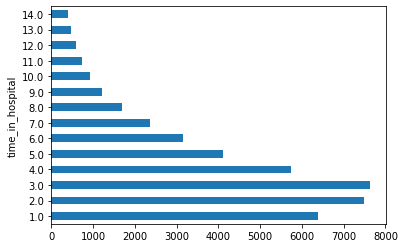

In [23]:
show_group_stats_viz(d_train, PREDICTOR_FIELD)

time_in_hospital
1.0     2195
2.0     2492
3.0     2520
4.0     1929
5.0     1320
6.0     1014
7.0      794
8.0      597
9.0      379
10.0     334
11.0     259
12.0     171
13.0     171
14.0     128
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


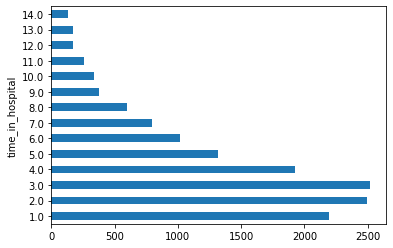

In [24]:
show_group_stats_viz(d_test, PREDICTOR_FIELD)

## Demographic Group Analysis

We should check that our partitions/splits of the dataset are similar in terms of their demographic profiles. Below is shown how we might visualize and analyze the full dataset vs. the partitions.

gender
Female             38025
Male               33490
Unknown/Invalid        3
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


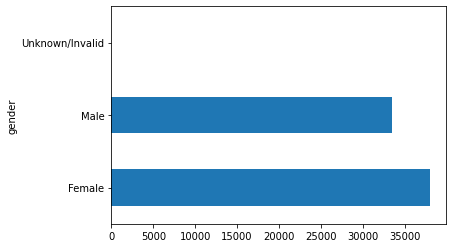

In [25]:
# Full dataset before splitting
patient_demo_features = ['race', 'gender', 'age', 'patient_nbr']
patient_group_analysis_df = processed_df[patient_demo_features].groupby('patient_nbr').head(1).reset_index(drop=True)
show_group_stats_viz(patient_group_analysis_df, 'gender')

gender
Female             22749
Male               20160
Unknown/Invalid        2
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


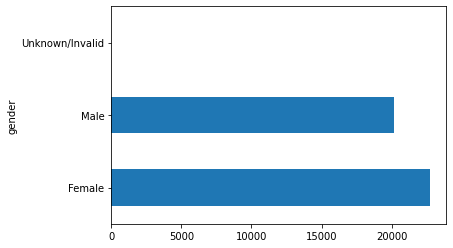

In [26]:
# Training partition
show_group_stats_viz(d_train, 'gender')

gender
Female    7651
Male      6652
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


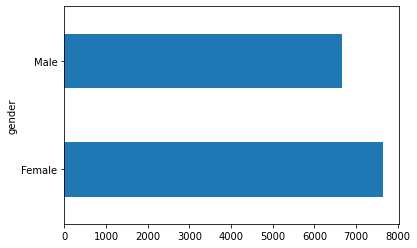

In [27]:
# Test partition
show_group_stats_viz(d_test, 'gender')

## Convert Dataset Splits to TF Dataset

In [28]:
# Convert dataset from Pandas dataframes to TF dataset 
batch_size = 128
diabetes_train_ds = df_to_dataset(d_train, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_val_ds = df_to_dataset(d_val, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_test_ds = df_to_dataset(d_test, PREDICTOR_FIELD, batch_size=batch_size)

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-05-19 22:13:37.305610: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-19 22:13:37.305721: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [29]:
# We use this sample of the dataset to show transformations later
diabetes_batch = next(iter(diabetes_train_ds))[0]
def demo(feature_column, example_batch):
    feature_layer = layers.DenseFeatures(feature_column)
    print(feature_layer(example_batch))

# 4. Create Categorical Features with TF Feature Columns

## Build Vocabulary for Categorical Features

Before we can create the TF categorical features, we must first create the vocab files with the unique values for a given field that are from the **training** dataset. The below function only requires providing the pandas train dataset partition and the list of the categorical columns in a list format. The output variable 'vocab_file_list' will be a list of the file paths that can be used in the next step for creating the categorical features.

In [30]:
vocab_file_list = build_vocab_files(d_train, categorical_col_list)

## Create Categorical Features with Tensorflow Feature Column API

Using the vocab file list from above that was derived from the features we selected earlier, we create categorical features with the Tensorflow Feature Column API, https://www.tensorflow.org/api_docs/python/tf/feature_column.

In [31]:
from project_utils import create_tf_categorical_feature_cols
tf_cat_col_list = create_tf_categorical_feature_cols(categorical_col_list)

INFO:tensorflow:vocabulary_size = 7 in race is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/race_vocab.txt.
INFO:tensorflow:vocabulary_size = 11 in weight is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/weight_vocab.txt.
INFO:tensorflow:vocabulary_size = 4 in gender is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/gender_vocab.txt.
INFO:tensorflow:vocabulary_size = 11 in age is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/age_vocab.txt.
INFO:tensorflow:vocabulary_size = 69 in medical_specialty is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/medical_specialty_vocab.txt.
INFO:tensorflow:vocabulary_size = 648 in primary_diagnosis_code is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/primary_diagnosis_code_vocab.txt.
INFO:tensorflow:vocabulary_size = 5 in max_glu_serum is inferred from the number of ele

In [32]:
test_cat_var1 = tf_cat_col_list[0]
print("Example categorical field:\n{}".format(test_cat_var1))
demo(test_cat_var1, diabetes_batch)

Example categorical field:
EmbeddingColumn(categorical_column=VocabularyFileCategoricalColumn(key='race', vocabulary_file='./diabetes_vocab/race_vocab.txt', vocabulary_size=7, num_oov_buckets=0, dtype=tf.string, default_value=-1, file_format=None), dimension=7, combiner='mean', initializer=<tensorflow.python.ops.init_ops.TruncatedNormal object at 0x120269df0>, ckpt_to_load_from=None, tensor_name_in_ckpt=None, max_norm=None, trainable=True, use_safe_embedding_lookup=True)
tf.Tensor(
[[-1.46702304e-01  1.45258158e-01 -7.19584748e-02  3.84965360e-01
  -1.26041442e-01  1.02305161e-02  3.14617872e-01]
 [-1.46702304e-01  1.45258158e-01 -7.19584748e-02  3.84965360e-01
  -1.26041442e-01  1.02305161e-02  3.14617872e-01]
 [-1.46702304e-01  1.45258158e-01 -7.19584748e-02  3.84965360e-01
  -1.26041442e-01  1.02305161e-02  3.14617872e-01]
 [ 1.17956884e-01  2.41816491e-01  3.24091256e-01  9.21025872e-02
   4.75231320e-01  1.32139623e-01 -1.27557501e-01]
 [-1.46702304e-01  1.45258158e-01 -7.19584748

# 5. Create Numerical Features with TF Feature Columns

Using the TF Feature Column API(https://www.tensorflow.org/api_docs/python/tf/feature_column/), we create normalized Tensorflow numeric features for the model. We use the z-score normalizer function below to help as well as the 'calculate_stats_from_train_data' function.

In [33]:
from project_utils import create_tf_numeric_feature

For simplicity the create_tf_numerical_feature_cols function below uses the same normalizer function across all features(z-score normalization) but if you have time feel free to analyze and adapt the normalizer based off the statistical distributions. You may find this as a good resource in determining which transformation fits best for the data https://developers.google.com/machine-learning/data-prep/transform/normalization.


In [40]:
def calculate_stats_from_train_data(df, col):
    df[col] = pd.to_numeric(df[col])
    mean = df[col].describe()['mean']
    std = df[col].describe()['std']
    return mean, std

def create_tf_numerical_feature_cols(numerical_col_list, train_df):
    tf_numeric_col_list = []
    for c in numerical_col_list:
        mean, std = calculate_stats_from_train_data(train_df, c)
        tf_numeric_feature = create_tf_numeric_feature(c, mean, std)
        tf_numeric_col_list.append(tf_numeric_feature)
    return tf_numeric_col_list

In [44]:
tf_cont_col_list = create_tf_numerical_feature_cols(numerical_col_list, d_train)

In [68]:
diabetes_batch['number_outpatient']

<tf.Tensor: shape=(128,), dtype=string, numpy=
array([b'0', b'0', b'0', b'0', b'0', b'0', b'0', b'0', b'0', b'1', b'0',
       b'2', b'0', b'0', b'0', b'0', b'0', b'0', b'0', b'0', b'0', b'3',
       b'0', b'0', b'0', b'1', b'0', b'0', b'1', b'7', b'0', b'0', b'0',
       b'0', b'0', b'0', b'0', b'0', b'0', b'0', b'0', b'0', b'0', b'0',
       b'2', b'0', b'0', b'1', b'0', b'2', b'0', b'0', b'0', b'0', b'4',
       b'0', b'0', b'0', b'0', b'0', b'0', b'0', b'0', b'1', b'0', b'0',
       b'1', b'0', b'0', b'1', b'2', b'0', b'0', b'0', b'0', b'0', b'0',
       b'0', b'0', b'0', b'0', b'0', b'0', b'0', b'1', b'0', b'0', b'0',
       b'0', b'0', b'0', b'0', b'2', b'0', b'0', b'0', b'1', b'0', b'0',
       b'0', b'0', b'0', b'0', b'0', b'0', b'0', b'0', b'0', b'0', b'0',
       b'0', b'4', b'1', b'0', b'0', b'0', b'0', b'0', b'0', b'0', b'0',
       b'0', b'1', b'1', b'0', b'0', b'0', b'0'], dtype=object)>

In [63]:
test_cont_var1 = tf_cont_col_list[0]
print("Example continuous field:\n{}\n".format(test_cont_var1))
demo(test_cont_var1, np.asarray(diabetes_batch['number_outpatient']).astype('float32'))

Example continuous field:
NumericColumn(key='number_outpatient', shape=(1,), default_value=(0,), dtype=tf.float32, normalizer_fn=<function normalize_numeric_with_zscore.<locals>.zscaler at 0x2d1f02dc0>)



ValueError: Exception encountered when calling layer "dense_features_8" (type DenseFeatures).

We expected a dictionary here. Instead we got: 

Call arguments received by layer "dense_features_8" (type DenseFeatures):
  • features=tf.Tensor(shape=(128,), dtype=float32)
  • cols_to_output_tensors=None
  • training=False

# 6. Build Deep Learning Regression Model with Sequential API and TF Probability Layers

## Use DenseFeatures to combine features for model

Now that we have prepared categorical and numerical features using Tensorflow's Feature Column API, we can combine them into a dense vector representation for the model. Below we will create this new input layer, which we will call 'claim_feature_layer'.

In [ ]:
claim_feature_columns = tf_cat_col_list + tf_cont_col_list
claim_feature_layer = tf.keras.layers.DenseFeatures(claim_feature_columns)

## Build Sequential API Model from DenseFeatures and TF Probability Layers

Below we have provided some boilerplate code for building a model that connects the Sequential API, DenseFeatures, and Tensorflow Probability layers into a deep learning model. There are many opportunities to further optimize and explore different architectures through benchmarking and testing approaches in various research papers, loss and evaluation metrics, learning curves, hyperparameter tuning, TF probability layers, etc. Feel free to modify and explore as you wish.

**Future Recomendation**: Come up with a more optimal neural network architecture and hyperparameters. Share the process in discovering the architecture and hyperparameters.

In [ ]:
def build_sequential_model(feature_layer):
    model = tf.keras.Sequential([
        feature_layer,
        tf.keras.layers.Dense(150, activation='relu'),
        tf.keras.layers.Dense(75, activation='relu'),
        tfp.layers.DenseVariational(1+1, posterior_mean_field, prior_trainable),
        tfp.layers.DistributionLambda(
            lambda t:tfp.distributions.Normal(loc=t[..., :1],
                                             scale=1e-3 + tf.math.softplus(0.01 * t[...,1:])
                                             )
        ),
    ])
    return model

def build_diabetes_model(train_ds, val_ds,  feature_layer,  epochs=5, loss_metric='mse'):
    model = build_sequential_model(feature_layer)
    model.compile(optimizer='rmsprop', loss=loss_metric, metrics=[loss_metric])
    early_stop = tf.keras.callbacks.EarlyStopping(monitor=loss_metric, patience=3)     
    history = model.fit(train_ds, validation_data=val_ds,
                        callbacks=[early_stop],
                        epochs=epochs)
    return model, history 

In [ ]:
diabetes_model, history = build_diabetes_model(diabetes_train_ds, diabetes_val_ds,  claim_feature_layer,  epochs=10)

## Show Model Uncertainty Range with TF Probability

Now that we have trained a model with the TF Probability layers, we can extract the mean and standard deviation for each prediction.

In [ ]:
feature_list = student_categorical_col_list + student_numerical_col_list
diabetes_x_tst = dict(d_test[feature_list])
diabetes_yhat = diabetes_model(diabetes_x_tst)
preds = diabetes_model.predict(diabetes_test_ds)

In [ ]:
from project_utils import get_mean_std_from_preds
m, s = get_mean_std_from_preds(diabetes_yhat)

## Show Prediction Output 

In [ ]:
prob_outputs = {
    "pred": preds.flatten(),
    "actual_value": d_test['time_in_hospital'].values,
    "pred_mean": m.numpy().flatten(),
    "pred_std": s.numpy().flatten()
}
prob_output_df = pd.DataFrame(prob_outputs)

In [ ]:
prob_output_df.head()

## Convert Regression Output to Classification Output for Patient Selection

Given the output predictions, we convert it to a binary label for whether the patient meets the time criteria or does not, using the mean prediction numpy array. The expected output is a numpy array with a 1 or 0 based off if the prediction meets or doesnt meet the criteria.

In [ ]:
from project_utils import get_student_binary_prediction
student_binary_prediction = get_student_binary_prediction(prob_output_df, 'pred_mean')

### Add Binary Prediction to Test Dataframe

Using the *student_binary_prediction* output that is a numpy array with binary labels, we can use this to add to a dataframe to better visualize and also to prepare the data for the Aequitas toolkit. The Aequitas toolkit requires that the predictions be mapped to a binary label for the predictions (called 'score' field) and the actual value (called 'label_value').

In [ ]:
def add_pred_to_test(test_df, pred_np, demo_col_list):
    for c in demo_col_list:
        test_df[c] = test_df[c].astype(str)
    test_df['score'] = pred_np
    test_df['label_value'] = test_df['time_in_hospital'].apply(lambda x: 1 if x >=5 else 0)
    return test_df

pred_test_df = add_pred_to_test(d_test, student_binary_prediction, ['race', 'gender'])

In [ ]:
pred_test_df[['patient_nbr', 'gender', 'race', 'time_in_hospital', 'score', 'label_value']].head()

## Model Evaluation Metrics 

Now we can use the newly created binary labels in the *'pred_test_df'* dataframe to evaluate the model with some common classification metrics.

Two things we should consider:
- With a non-technical audience in mind, what is the precision-recall tradeoff in regard to the model was optimized.

- What are some areas of improvement for future iterations?

In [ ]:
# AUC, F1, precision and recall
# Summary

# 7. Evaluating Potential Model Biases with Aequitas Toolkit

## Prepare Data For Aequitas Bias Toolkit 

Using the gender and race fields, we will prepare the data for the Aequitas Toolkit.

In [ ]:
# Aequitas
from aequitas.preprocessing import preprocess_input_df
from aequitas.group import Group
from aequitas.plotting import Plot
from aequitas.bias import Bias
from aequitas.fairness import Fairness

ae_subset_df = pred_test_df[['race', 'gender', 'score', 'label_value']]
ae_df, _ = preprocess_input_df(ae_subset_df)
g = Group()
xtab, _ = g.get_crosstabs(ae_df)
absolute_metrics = g.list_absolute_metrics(xtab)
clean_xtab = xtab.fillna(-1)
aqp = Plot()
b = Bias()


## Reference Group Selection

Below we have chosen the reference group for our analysis but feel free to select another one.

In [ ]:
# test reference group with Caucasian Male
bdf = b.get_disparity_predefined_groups(clean_xtab, 
                    original_df=ae_df, 
                    ref_groups_dict={'race':'Caucasian', 'gender':'Male'
                                     }, 
                    alpha=0.05, 
                    check_significance=False)


f = Fairness()
fdf = f.get_group_value_fairness(bdf)

## Race and Gender Bias Analysis for Patient Selection

For the gender and race fields, we plot two metrics that are important for patient selection below and state whether there is a significant bias in your model across any of the groups along with justification for your statement.

In [ ]:
# Plot two metrics

# Is there significant bias in your model for either race or gender?

## Fairness Analysis Example - Relative to a Reference Group 

Earlier we defined our reference group and then calculated disparity metrics relative to this grouping. Below is a visualization of the fairness evaluation for this reference group.

In [ ]:
# Reference group fairness plot